# Intro to PyTorch Hooks - Solutions


In [3]:
%matplotlib inline
import typing as t

# Mathematical operations
import numpy as np

# visualization
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Default network for testing
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_1 = nn.Linear(10, 20)
        self.fc_2 = nn.Linear(20, 30)
        self.fc_3 = nn.Linear(30, 2)
        self.relu = lambda x: F.relu(x)

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        first_output = self.fc_1(input_tensor)
        second_output = self.fc_2(first_output)
        third_output = self.fc_3(second_output)
        final_output = self.relu(third_output)
        return final_output

    
def get_pyplot_figure_for_batch(output_array: torch.Tensor) -> plt.figure:
    """
    Just use this to visualize the output of each layer
    """
    # Get the shape of the output tensor
    output_shape = output_array.shape    
    fig = plt.figure(figsize=(16, 16))
    for i in range(output_shape[2]):
        ax = fig.add_subplot(output_shape[2]//8 + 1, 8, i+1)
        if output_shape[2] == 1: # If only one channel, skip the last axis
            ax.imshow(output_array[:,:,0], cmap='gray', interpolation='nearest')
            ax.imshow(np.dstack((output_array[:,:,0], output_array[:,:,0], output_array[:,:,0])))
        else:
            ax.imshow(output_array[:,:,i], cmap='jet', interpolation='nearest')
            ax.imshow(np.dstack((output_array[:,:,i], output_array[:,:,i], output_array[:,:,i])))
        ax.axis('off')
    return fig


### Exercise 1.1

Given the `LinearModel` in the earlier section, using the PyTorch forward pre-hook.

1. Define an instance of `LinearModel`
2. Add a forward pre_hook to `fc_1` and `fc_3` that prints out the original input and the tensor shape.
3. Afterwards, try passing in a random tensor created using `torch.randn` or your function of choice and check whether the hook is working as intended.
4. Lastly, try removing the hook attached to `fc_3`. 
5. Afterwards, try passing in a random tensor created using `torch.randn` or your function of choice and check whether the hook to `fc_3` has been successfully removed.

In [4]:
# Solution 
# -----------------------------------

# Step 1
model = LinearModel()


# Step 2. Define the hook function
def forward_prehook(module: nn.Module, input_tuple: t.Tuple[torch.Tensor, ...]) -> None:
    # A better solution would be to iterate over the tuple and print, but oh well
    print(f'Input tuple shape: {input_tuple[0].shape}, Tensor: {input_tuple[0].shape}')

# Add the hooks
fc1_prehook_handle = model.fc_1.register_forward_pre_hook(forward_prehook)
fc3_prehook_handle = model.fc_3.register_forward_pre_hook(forward_prehook)

# 3. Pass in a random tensor
batch_size = 3
input_size = 10
random_tensor = torch.randn(batch_size, input_size)

# Forward pass
output = model(random_tensor)
print('Forward pass completed --------------')

# 4. Remove fc_3 hook
fc3_prehook_handle.remove()

# 5. Forward pass again
output = model(random_tensor)
print('Forward pass completed --------------') 


Input tuple shape: torch.Size([3, 10]), Tensor: torch.Size([3, 10])
Input tuple shape: torch.Size([3, 30]), Tensor: torch.Size([3, 30])
Forward pass completed --------------
Input tuple shape: torch.Size([3, 10]), Tensor: torch.Size([3, 10])
Forward pass completed --------------



### Exercise 1.2 

Right now, there is no way to add hooks onto the relu activation, because the `ReLU` activation is not implemented. 
The goal of this exercise is to

1. Try adding a forward pre-hook to the ReLU operation. It should fail.
2. Update the neural network so that we can add the forward pre-hook to the `ReLU` operation in the neural network above.
3. Create a random input tensor
4. Feed that random input tensor to the neural network and print the outputs
5. Add a forward pre-hook to the `ReLU` layer.
6. Feed the random input tensor from step 2 and check whether ReLU hook is working.


In [5]:
# Solution Exercise 1.2 here 
# -----------------------------------

class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_1 = nn.Linear(10, 20)
        self.fc_2 = nn.Linear(20, 30)
        self.fc_3 = nn.Linear(30, 2)
        self.relu = lambda x: F.relu(x)

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        first_output = self.fc_1(input_tensor)
        second_output = self.fc_2(first_output)
        third_output = self.fc_3(second_output)
        final_output = self.relu(third_output)
        return final_output

def relu_pre_hook(module, input_tensors: t.Tuple[torch.Tensor, ...]) -> t.Tuple[torch.Tensor, ...]:
    print(f'it is working!!!! {input_tensors}')

model = LinearModel()
try:
    # This should fail
    model.relu.register_forward_pre_hook(relu_pre_hook)
except AttributeError as e:
    print('Error: --------------')
    print(e)
    print('-' * 50)


# 1. Updated neural network
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_1 = nn.Linear(10, 20)
        self.fc_2 = nn.Linear(20, 30)
        self.fc_3 = nn.Linear(30, 2)
        # Convert relu to a nn.Module
        self.relu = nn.ReLU()

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        first_output = self.fc_1(input_tensor)
        second_output = self.fc_2(first_output)
        third_output = self.fc_3(second_output)
        final_output = self.relu(third_output)
        return final_output


model = LinearModel()

# 2. Create random input tensor
batch_size = 3
input_size = 10
random_tensor = torch.randn(batch_size, input_size)

# 3. Feed the random input tensor to Neural network
output = model(random_tensor)
print(output)

# 4. Add forward pre-hook to ReLU()
model.relu.register_forward_pre_hook(relu_pre_hook)

output = model(random_tensor)
print(output)

Error: --------------
'function' object has no attribute 'register_forward_pre_hook'
--------------------------------------------------
tensor([[0.0000, 0.0285],
        [0.1571, 0.1778],
        [0.1387, 0.2557]], grad_fn=<ReluBackward0>)
it is working!!!! (tensor([[-0.1663,  0.0285],
        [ 0.1571,  0.1778],
        [ 0.1387,  0.2557]], grad_fn=<AddmmBackward0>),)
tensor([[0.0000, 0.0285],
        [0.1571, 0.1778],
        [0.1387, 0.2557]], grad_fn=<ReluBackward0>)


### Exercise 2.1

Perform the following steps

1. Try adding a foward_hook to the relu layer. It should double the output of the ReLU activation.
2. Log and verify the results
3. Afterwards remove the hook and do a forward pass to ensure that it is working properly

In [21]:
# Solution
# -----------------------------------

model = LinearModel()
batch_size = 3
input_size = 10
random_tensor = torch.randn(batch_size, input_size)

# Before double
output = model(random_tensor)
print(output)

# 1. double output
def double_relu(module: nn.Module, 
                inputs: torch.Tensor, 
                outputs: torch.Tensor) -> torch.Tensor:
    return output * 2


relu_forward_hook = model.relu.register_forward_hook(double_relu)

# 2. Log and verify results
print('-' * 100)
output = model(random_tensor)
print(output)

# 3. Remove hook and do forward pass
relu_forward_hook.remove()
print('-' * 100)
print('I should be restored to normal')
output = model(random_tensor)
print(output)


tensor([[0.0000, 0.2667],
        [0.2076, 0.2881],
        [0.3127, 0.4713]], grad_fn=<ReluBackward0>)
----------------------------------------------------------------------------------------------------
tensor([[0.0000, 0.5334],
        [0.4152, 0.5761],
        [0.6253, 0.9426]], grad_fn=<MulBackward0>)
----------------------------------------------------------------------------------------------------
I should be restored to normal
tensor([[0.0000, 0.2667],
        [0.2076, 0.2881],
        [0.3127, 0.4713]], grad_fn=<ReluBackward0>)


### Exercise 2.2

The goal is to perform the following steps.

1. Analyze the `resnet18` 's modules. 
   1. Try looking at `.modules()`
2. After asssessing the network structure and module names, find a way to filter out all the modules that output convolutional feature maps
3. Add a forward hook to each of these convolutional modules so that we
   1. Visualize the first `four` convolutional layers using `matplotlib`
4. Feed the dog image into the neural network. You can also feel free to grab other images from the internet to test with.
5. Lastly, remove all the hooks registered to the neural network
6. Try feeding the dog image again to check that the forward hooks have properly been detached.

In [22]:
from PIL import Image
import torch
from torchvision.models import resnet18
from torchvision import transforms as T

# The starter code is copied from 
# https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/
# Please do not look at the sample code above before attempting this exercise and only 
# refer to it if you have are stuck

# input (single)
image = Image.open('puppy.jpg')
transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
input_image = transform(image).unsqueeze(dim=0)

# original model
model = resnet18(pretrained=True)

# Solution for 2.2 - 
# it is very similar to the exercise in the given example, so skip if it you are running out of time
# TODO: When you have time, write out solutions
# -----------------------------------

/Users/jaylee/machine-learning/230408_pytorch_hooks/pytorch_hooks/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jaylee/machine-learning/230408_pytorch_hooks/pytorch_hooks/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Exercise 3.1

One very useful technique when training neural networks is a technique called "Gradient Clipping". 
It is a very useful techique to prevent exploding gradients when training neural networks. 
Exploding gradients are a very common issue when training Recurrent neural network, due to the 
backpropagation through time technique. 

An example of Gradient clipping is something like the following:

"If the gradient becomes greater than 10, set it to 10".

Gradient clipping can be implemented using PyTorch backward hooks (there is also a function for it, but assume that it doesn't exist). 

Your goal is to implement gradient clipping in the exercise and to check the gradient values to ensure that it is working correctly. 
Use the previous network (`resnet18`) from the previous exercise and try feeding the dog image.

1. Write a backward hook that clips gradients that are greater than `gradient_threshold` where, the value `gradient_threshold` is a variable. Feel free to use either ResNet18 or a simple model of your choice.
2. Visualize the gradient via printing onto the console
   1. If you are feeling adventurous, try logging the results onto TensorBoard (not that difficult)
3. Check the gradients to ensure that the gradients are being properly clipped. 
   1. Try setting the threshold to various values and experiment with your implementation.

Leverage the given neural network and model to work with the value.

Forward: ouput_shape: torch.Size([20])
Forward: ouput_shape: torch.Size([30])
Forward: ouput_shape: torch.Size([2])
Backward input gradient -- shape: torch.Size([2])
Backward input gradient -- shape: torch.Size([10, 30])
Backward input gradient -- shape: torch.Size([30, 2])
Backward output gradient -- shape: torch.Size([10, 2])
Backward input gradient -- shape: torch.Size([30])
Backward input gradient -- shape: torch.Size([10, 20])
Backward input gradient -- shape: torch.Size([20, 30])
Backward output gradient -- shape: torch.Size([10, 30])
Backward input gradient -- shape: torch.Size([20])
Backward input gradient -- Not a leaf node. Only leaf nodes accumulate gradients
Backward input gradient -- shape: torch.Size([10, 20])
Backward output gradient -- shape: torch.Size([10, 20])


/Users/jaylee/machine-learning/230408_pytorch_hooks/pytorch_hooks/lib/python3.11/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


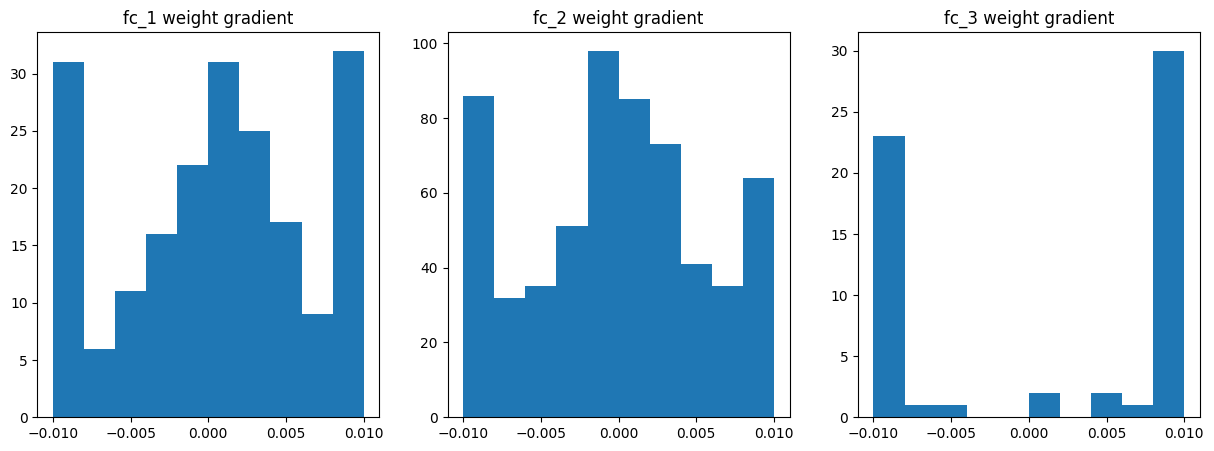

In [23]:
# Default network for testing
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_1 = nn.Linear(10, 20)
        self.fc_2 = nn.Linear(20, 30)
        self.fc_3 = nn.Linear(30, 2)
        self.relu = nn.ReLU()

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        first_output = self.fc_1(input_tensor)
        second_output = self.fc_2(first_output)
        third_output = self.fc_3(second_output)
        final_output = self.relu(third_output)
        return final_output

# Define a backward hook to clip the gradients
def clip_grads(module: nn.Module, 
               grad_in: t.Tuple[torch.Tensor, ...], 
               grad_out: t.Tuple[torch.Tensor, ...]):
    gradient_threshold = 0.01
    for grad in grad_in:
        if grad is not None:
            print(f'Backward input gradient -- shape: {grad.shape}')
            clipped_grad = torch.clamp(grad, -gradient_threshold, gradient_threshold)
            grad.copy_(clipped_grad)
        else:
            print('Backward input gradient -- Not a leaf node. Only leaf nodes accumulate gradients')
    
    # Output gradients
    # For more information on how these are calculated, try reading up on autograd
    # Essentially, we do a dot product with the transpose of the 
    # Jaocbian vector matrix x vector of gradients from a scalar function (think CE loss or MSE)
    # Think of the second element in shape as the size of the previous layer (DL / D_theta_0, theta_1, ... theta_n) = 
    # Jacobian
    for grad in grad_out:
        if grad is not None:
            print(f'Backward output gradient -- shape: {grad.shape}')
        else:
            print('Backward output gradient -- Not a leaf node. Only leaf nodes accumulate gradients')
        


def forward_hook(module, input, output):
    print(f'Forward: ouput_shape: {output[0].shape}')

# Generate some input and target tensors for testing
batch_size = 10
input_tensor = torch.randn((batch_size, 10))
target_tensor = torch.tensor([0, 1])
target_tensor = target_tensor.repeat(5)  # repeat the target tensor to match the batch size

# Initialize the model and loss function
model = LinearModel()
loss_function = nn.CrossEntropyLoss()

# Attach backward hooks to the linear layers
model.fc_1.register_backward_hook(clip_grads)
model.fc_2.register_backward_hook(clip_grads)
model.fc_3.register_backward_hook(clip_grads)

model.fc_1.register_forward_hook(forward_hook)
model.fc_2.register_forward_hook(forward_hook)
model.fc_3.register_forward_hook(forward_hook)

# Forward pass
output_tensor = model(input_tensor)
loss = loss_function(output_tensor, target_tensor)

# Backward pass
model.zero_grad()
# This will trigger all the backward hooks
loss.backward()

# Visualize the gradients
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(model.fc_1.weight.grad.flatten())
axs[0].set_title('fc_1 weight gradient')
axs[1].hist(model.fc_2.weight.grad.flatten())
axs[1].set_title('fc_2 weight gradient')
axs[2].hist(model.fc_3.weight.grad.flatten())
axs[2].set_title('fc_3 weight gradient')
plt.show()